In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
class DataPipeline:
    def __init__(self, path):
        self.path = path
        self.df = None
        self.num_cols = []
        self.cat_cols = []

    def load_data(self):
        self.df = pd.read_csv(self.path)
        self.num_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.cat_cols = self.df.select_dtypes(exclude=[np.number]).columns.tolist()
        print(f"Загружено {self.df.shape[0]} строк и {self.df.shape[1]} колонок")
        return self.df
    
    def overview(self):
        display(self.df.head())
        print(self.df.info())
        display(self.df.describe(include='all'))

    def clip_outliers(self, factor=1.5):
        cols_to_process = [col for col in self.num_cols if col != 'heart_disease']
        for col in cols_to_process:
            q1, q3 = self.df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            low, high = q1 - factor*iqr, q3 + factor*iqr
            self.df[col] = self.df[col].clip(lower=low, upper=high)
        print("Выбросы в числовых признаках обработаны (методом clip)")

    def encode_categoricals(self):
        for col in self.cat_cols:
            if self.df[col].nunique() == 2:
                mapping = {val: idx for idx, val in enumerate(self.df[col].unique())}
                self.df[col] = self.df[col].map(mapping)
        
        cat_cols_to_encode = self.df.select_dtypes(exclude=[np.number]).columns.tolist()
        if cat_cols_to_encode:
             self.df = pd.get_dummies(self.df, columns=cat_cols_to_encode, drop_first=True)
        print("Категориальные признаки закодированы")


    def drop_useless_columns(self):
        drop_cols = [
            "full_name", "first_name", "last_name",
            "treatment_date", "country", "hospital"
        ]
        cols_to_drop_exist = [col for col in drop_cols if col in self.df.columns]
        self.df.drop(columns=cols_to_drop_exist, inplace=True)
        self.num_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.cat_cols = self.df.select_dtypes(exclude=[np.number]).columns.tolist()
        print(f"Удалены ненужные колонки: {cols_to_drop_exist}")

In [3]:
PATH_TO_DATA = "../lab4/Heart_Disease_and_Hospitals.csv" 

pipeline = DataPipeline(PATH_TO_DATA)
df = pipeline.load_data()

pipeline.drop_useless_columns()
pipeline.clip_outliers()
pipeline.encode_categoricals()

df_processed = pipeline.df
print("\nОбзор обработанных данных:")
df_processed.info()
df_processed.head()

Загружено 10000 строк и 15 колонок
Удалены ненужные колонки: ['full_name', 'first_name', 'last_name', 'treatment_date', 'country', 'hospital']
Выбросы в числовых признаках обработаны (методом clip)
Категориальные признаки закодированы

Обзор обработанных данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       10000 non-null  int64  
 1   blood_pressure            10000 non-null  float64
 2   cholesterol               10000 non-null  float64
 3   bmi                       10000 non-null  float64
 4   glucose_level             10000 non-null  float64
 5   gender                    10000 non-null  int64  
 6   heart_disease             10000 non-null  int64  
 7   state_Alaska              10000 non-null  bool   
 8   state_Arizona             10000 non-null  bool   
 9   state_Arkansas     

,age,blood_pressure,cholesterol,bmi,glucose_level,gender,heart_disease,state_Alaska,state_Arizona,state_Arkansas,...,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,treatment_Medication,treatment_Physiotherapy,treatment_Rehabilitation,treatment_Surgery
0,21,138.068129,270.564349,36.101427,63.487954,0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,44,100.383639,160.910030,14.330471,187.008977,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,22,145.618318,208.490251,20.277098,35.903576,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,19,152.577870,348.153738,55.744766,31.495166,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,64,111.793570,200.628925,14.468485,154.513129,0,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [4]:
X = df_processed.drop(columns=["heart_disease"])
y = df_processed["heart_disease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (8000, 59)
Размер тестовой выборки: (2000, 59)


In [5]:
base_gb_model = GradientBoostingClassifier(random_state=42)
base_gb_model.fit(X_train_scaled, y_train)
y_pred_base = base_gb_model.predict(X_test_scaled)

In [6]:
accuracy = accuracy_score(y_test, y_pred_base)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_base))

Accuracy: 0.9355

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       999
           1       0.93      0.94      0.94      1001

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



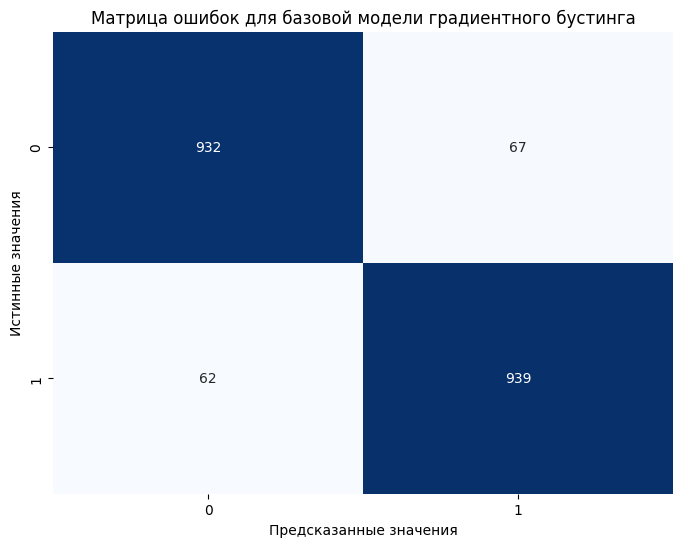

In [7]:
cm = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Матрица ошибок для базовой модели градиентного бустинга')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()


Тестирование конфигурации 'A'
{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05}

Тестирование конфигурации 'B'
{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}

Тестирование конфигурации 'C'
{'n_estimators': 200, 'max_depth': None, 'learning_rate': 0.2}

Тестирование конфигурации 'D'
{'n_estimators': 150, 'max_depth': None, 'learning_rate': 0.1}

Тестирование конфигурации 'E'
{'max_depth': 6, 'learning_rate': 0.05}

Тестирование конфигурации 'E'
{'n_estimators': 500, 'max_depth': 20}


,Конфигурация,Test Accuracy
0,A,0.9340
1,B,0.9475
2,C,0.9135
3,D,0.9145
4,E,0.9440
5,E,0.9200


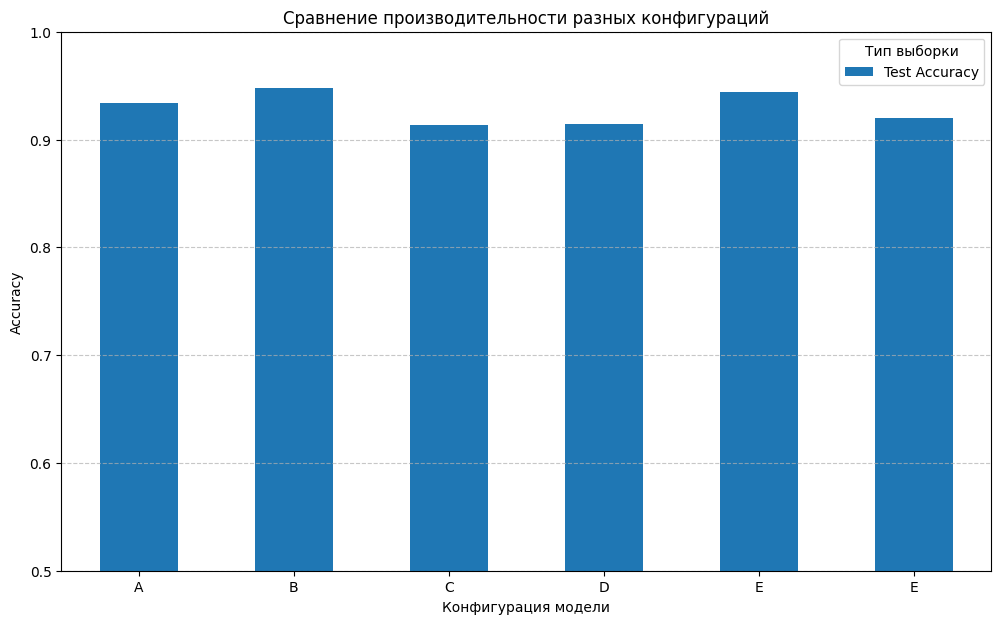

In [10]:
param_configs = [
    {
        'name': 'A',
        'n_estimators': 50,
        'max_depth': 5,
        'learning_rate': 0.05
    },
    {
        'name': 'B',
        'n_estimators': 100,
        'max_depth': 10,
        'learning_rate': 0.1
    },
    {
        'name': 'C',
        'n_estimators': 200,
        'max_depth': None, 
        'learning_rate': 0.2
    },
    {
        'name': 'D',
        'n_estimators': 150,
        'max_depth': None,
        'learning_rate': 0.1
    },
    {
        'name': 'E',
        'n_estimators': None,
        'max_depth': 6,
        'learning_rate': 0.05
    },
    {
        'name': 'E',
        'n_estimators': 500,
        'max_depth': 20,
        'learning_rate': None 
    },
]

results = []

for i, config in enumerate(param_configs):
    params = {
        k: v for k, v in config.items()
        if 
        k != 'name' and 
        not (k == 'n_estimators' and v is None) and
        not (k == 'learning_rate' and v is None)
    }
    
    print(f"\nТестирование конфигурации '{config['name']}'")
    print(params)
    
    rf = GradientBoostingClassifier(**params, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    y_train_pred = rf.predict(X_train_scaled)
    y_test_pred = rf.predict(X_test_scaled)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    results.append({
        'Конфигурация': config['name'],
        'Test Accuracy': test_accuracy
    })



results_df = pd.DataFrame(results)

display(results_df)

results_df.set_index('Конфигурация', inplace=True)

results_df.plot(kind='bar', figsize=(12, 7))
plt.title('Сравнение производительности разных конфигураций')
plt.ylabel('Accuracy')
plt.xlabel('Конфигурация модели')
plt.xticks(rotation=0)
plt.ylim(0.5, 1.0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Тип выборки')
plt.show()

In [16]:
param_grid = {
    'n_estimators': [100, 150, 200],    
    'learning_rate': [0.05, 0.1, 0.2], 
    'max_depth': [3, 5, 10, None],             
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  
    verbose=2,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 150, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [17]:

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Лучший показатель (Accuracy) на кросс-валидации: {grid_search.best_score_:.4f}")
print(f"Лучший показатель (Accuracy) на тестовых данных: {test_accuracy:.4f}")
print("Лучшие параметры, найденные GridSearchCV:")
print(grid_search.best_params_)

Лучший показатель (Accuracy) на кросс-валидации: 0.9366
Лучший показатель (Accuracy) на тестовых данных: 0.9440
Лучшие параметры, найденные GridSearchCV:
{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}


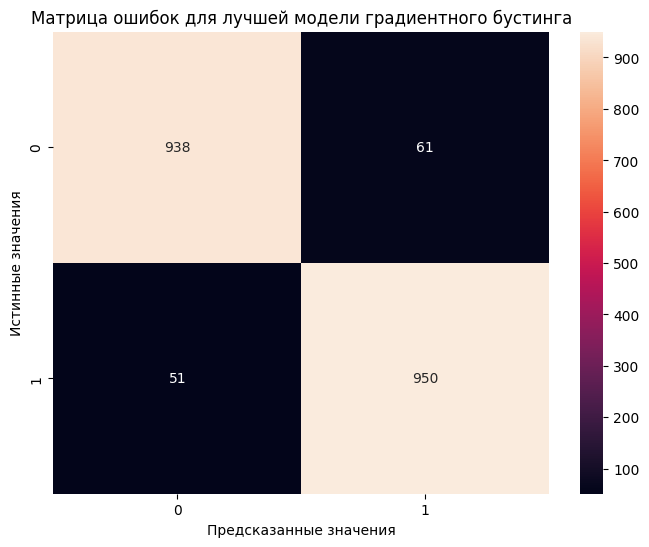

In [18]:
cm_best = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d')
plt.title('Матрица ошибок для лучшей модели градиентного бустинга')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

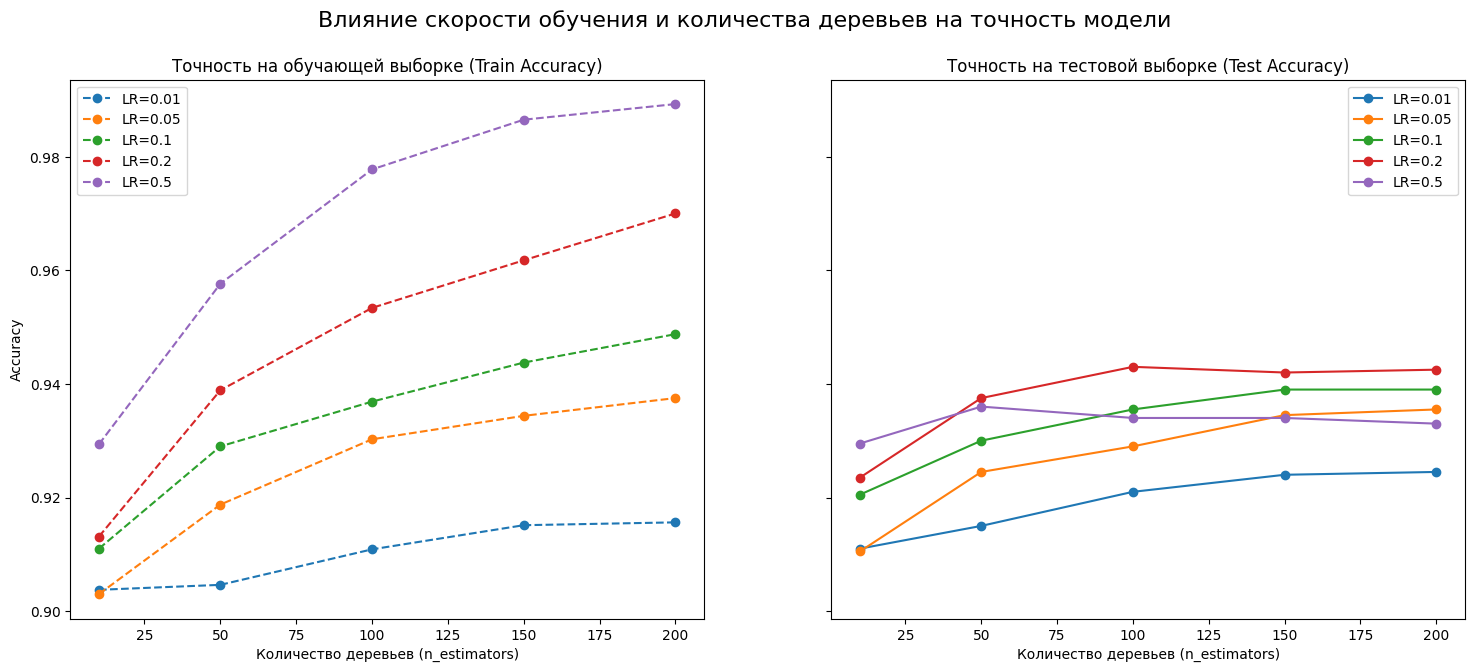

In [19]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
n_estimators_list = [10, 50, 100, 150, 200]

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for lr in learning_rates:
    train_scores = []
    test_scores = []
    
    for n_estimators in n_estimators_list:
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators, 
            learning_rate=lr, 
            random_state=42,
            max_depth=3 
        )
        gb.fit(X_train_scaled, y_train)
        
        train_scores.append(accuracy_score(y_train, gb.predict(X_train_scaled)))
        test_scores.append(accuracy_score(y_test, gb.predict(X_test_scaled)))

    axes[0].plot(n_estimators_list, train_scores, 'o--', label=f'LR={lr}')
    axes[1].plot(n_estimators_list, test_scores, 'o-', label=f'LR={lr}')

axes[0].set_title('Точность на обучающей выборке (Train Accuracy)')
axes[0].set_xlabel('Количество деревьев (n_estimators)')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].set_title('Точность на тестовой выборке (Test Accuracy)')
axes[1].set_xlabel('Количество деревьев (n_estimators)')
axes[1].legend()

fig.suptitle('Влияние скорости обучения и количества деревьев на точность модели', fontsize=16)
plt.show()